# ResNet152

In [ ]:
# 🔹 Data Handling
import numpy as np
import pandas as pd
import hashlib
import zipfile
import gdown
import random

# 🔹 Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 🔹 Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 TensorFlow Utils
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# 🔹 Mlflow -> tracking
from utils.MLFlowTrackingConfig import MLFlowTracking

2025-04-22 13:18:25.200634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745327905.442411      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745327905.511998      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# load the dataset

data = np.load('../artifacts/data_ingestion/Preprocessed Dataset/train_data.npz')

# X
X = data['arr_0']

# y
y = data['arr_1']

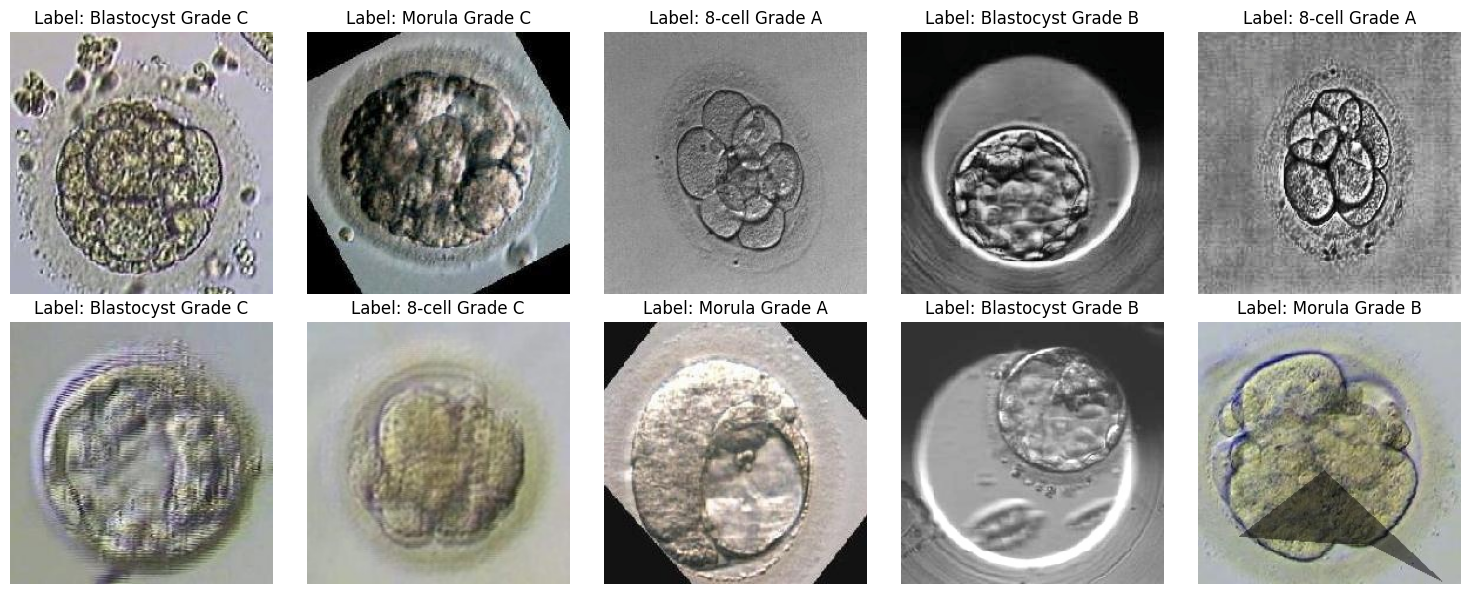

In [ ]:
# Randomly show the first 10 images 

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random.sample(range(len(X)), 10)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx].astype('uint8'))
    plt.title(f"Label: {y[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# shape

X.shape

(8621, 224, 224, 3)

In [7]:
# labels counts

pd.Series(y).value_counts()

Morula Grade C        900
Morula Grade B        900
Morula Grade A        900
Error Images          899
Blastocyst Grade C    893
Blastocyst Grade B    881
Blastocyst Grade A    876
8-cell Grade A        802
8-cell Grade C        796
8-cell Grade B        774
Name: count, dtype: int64

In [8]:
# now handel the labels

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_encoded = label_encoder.fit_transform(y)

# matrix
labels = to_categorical(y_encoded, len(label_encoder.classes_))

In [9]:
# show the first five labels

labels[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [10]:
# train and test split 

x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size= 0.1, random_state=42, stratify = labels)

In [11]:
# check the shape -> train

x_train.shape, y_train.shape

((7758, 224, 224, 3), (7758, 10))

In [12]:
# check the shape -> test

x_test.shape, y_test.shape

((863, 224, 224, 3), (863, 10))

In [13]:
# Model

# image size
input_shape = (224, 224, 3)  

# base model
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model
base_model.trainable = False

I0000 00:00:1745328155.841786      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745328155.842472      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# 🔹 Custom head

inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152 (Functional)               │ (None, 7, 7, 2048)          │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,929,674 (224.80 MB)

 Trainable params: 558,730 (2.13 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [16]:
# 🔹 Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# 🔹 Callbacks

# early stop
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# reduce the learning rate
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

In [19]:
# 🔹 Train

history = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100,
          batch_size=32,
          callbacks=[early_stop, reduce_lr])

Epoch 1/100


I0000 00:00:1745328237.437244     119 service.cc:148] XLA service 0x7b29a002b2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745328237.438219     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745328237.438243     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745328241.221880     119 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745328246.840506     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


243/243 ━━━━━━━━━━━━━━━━━━━━ 121s 328ms/step - accuracy: 0.4931 - loss: 1.3429 - val_accuracy: 0.6176 - val_loss: 0.8720 - learning_rate: 0.0010
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 57s 233ms/step - accuracy: 0.7105 - loss: 0.7092 - val_accuracy: 0.7543 - val_loss: 0.6170 - learning_rate: 0.0010
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 56s 232ms/step - accuracy: 0.7984 - loss: 0.4918 - val_accuracy: 0.8285 - val_loss: 0.4618 - learning_rate: 0.0010
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 56s 232ms/step - accuracy: 0.8578 - loss: 0.3724 - val_accuracy: 0.7879 - val_loss: 0.5660 - learning_rate: 0.0010
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 57s 233ms/step - accuracy: 0.8733 - loss: 0.3264 - val_accuracy: 0.8644 - val_loss: 0.3832 - learning_rate: 0.0010
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 56s 231ms/step - accuracy: 0.9168 - loss: 0.2409 - val_accuracy: 0.8424 - val_loss: 0.4131 - learning_rate: 0.0010
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 56s 231ms/step - accuracy: 0.9095 

In [ ]:
# Save the model 

model.save("ResNet152.h5")

**Train and Validation Loss Plot**


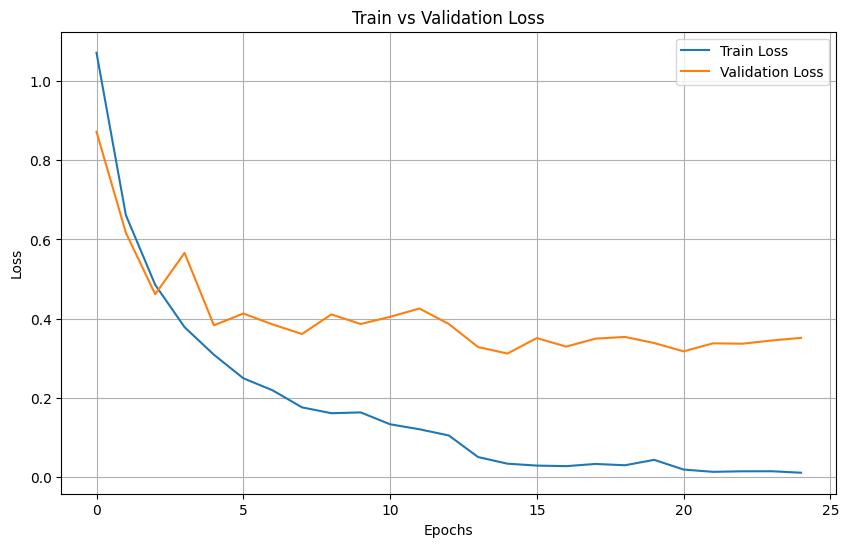

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Train and Validation Accuracy Plot**

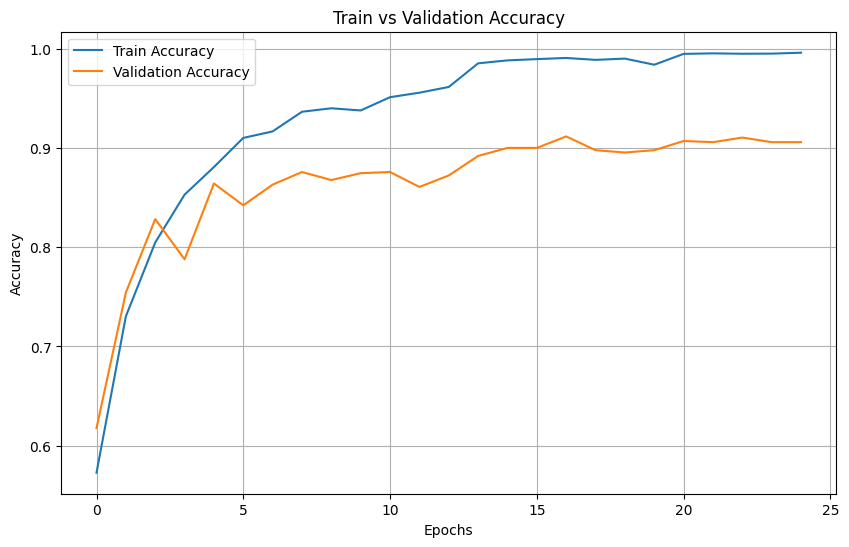

In [22]:
train_acc = history.history['accuracy']  
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation 

### Test data

In [23]:
test_data = np.load('/kaggle/working/test_data.npz')

X_test = test_data['arr_0']

y_test = test_data['arr_1']

In [24]:
labelEncodeY = LabelEncoder()

y_test = labelEncodeY.fit_transform(y_test)

y_test = to_categorical(y_test, len(labelEncodeY.classes_))

y_test = np.array(y_test)

In [25]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1, batch_size = 16)

print(f"🧪 Test Accuracy: {test_accuracy * 100:.2f}%")

print(f"📉 Test Loss: {test_loss:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.8926 - loss: 0.4063
🧪 Test Accuracy: 89.46%
📉 Test Loss: 0.3690


### Train data

In [26]:
train_data = np.load('/kaggle/working/train_data.npz')

X_train = train_data['arr_0']

y_train = train_data['arr_1']

In [27]:
labelEncodeY = LabelEncoder()

y_train = labelEncodeY.fit_transform(y_train)

y_train = to_categorical(y_train, len(labelEncodeY.classes_))

y_train = np.array(y_train)

In [28]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=1, batch_size = 8)

print(f"🧪 Train Accuracy: {train_accuracy * 100:.2f}%")

print(f"📉 Train Loss: {train_loss:.4f}")

1078/1078 ━━━━━━━━━━━━━━━━━━━━ 80s 70ms/step - accuracy: 0.9821 - loss: 0.0602
🧪 Train Accuracy: 98.29%
📉 Train Loss: 0.0554


### 🏷️ Update MLflow Tracking Configuration for Remote 

In [3]:
MLFlowTracking(model, 224, 3, 32, False, 100, 10, 'imagenet',  2.5000e-04, 0.3515,  0.9821, 0.8926, 'ResNet152')

Accessing as revanth-kumar-01-ai

Initialized MLflow to track repo "revanth-kumar-01-ai/360DigitMG-Training-Phase"

Repository revanth-kumar-01-ai/360DigitMG-Training-Phase initialized!

2025/04/22 19:45:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/22 19:45:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'ResNet152'.
2025/04/22 19:48:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ResNet152, version 1
Created version '1' of model 'ResNet152'.


🏃 View run valuable-moth-973 at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0/runs/fa80e125920145568999375aa8d5af8c
🧪 View experiment at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0
✅ MLflow tracking logged successfully! 🚀
